# setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from MetabolomicsPaper.GeneralHelperFunctions import *
# from ACSPaper.Matching import *
from ACSPaper.ACSPaperUtils import *
from sklearn.metrics import roc_curve, auc
import shap
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS

paper_dir = '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Cardio/ACS_study/v2/'
curr_dir = os.path.join(paper_dir, 'metacardis_metabolomics_model_of_bmi')
make_dir_if_not_exists(curr_dir)
os.chdir(paper_dir)

In [4]:
learning_rate = [0.1, 0.05, 0.02, 0.015, 0.01, 0.0075, 0.005, 0.002, 0.001, 0.0005, 0.0001]
num_leaves = range(2, 35)
max_depth = [-1, 2, 3, 4, 5, 10, 20, 40, 50]
min_data_in_leaf = range(1, 45, 2)
feature_fraction = [i / 10. for i in range(2, 11)]  # [1] when using dummy variables
metric = ['l2']
early_stopping_rounds = [None]
# early_stopping_rounds = [10, 20, 50]
num_threads = [1]
verbose = [-1]
silent = [True]
n_estimators = range(100, 500, 50)
bagging_fraction = [i / 10. for i in range(2, 11)]
bagging_freq = [0, 1, 2]
lambda_l1 = [0, 0.001, 0.005, 0.01, 0.1]

# Lasso params
alpha = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]


lightgbm_rscv_space = {'learning_rate': learning_rate, 'max_depth': max_depth,
                       'feature_fraction': feature_fraction, 'num_leaves': num_leaves,
                       'min_data_in_leaf': min_data_in_leaf, 'metric': metric,
                       'early_stopping_rounds': early_stopping_rounds, 'n_estimators': n_estimators,
                       'bagging_fraction': bagging_fraction, 'bagging_freq': bagging_freq,
                       'num_threads': num_threads, 'verbose': verbose, 'silent': silent, 'lambda_l1': lambda_l1}

# load data

In [70]:
metabolon_res = pd.read_csv(os.path.join(paper_dir, 'metacardis_replications', 'ACS-nonACS_metabolite_enrichments_full.csv'))
metabolon_res

,BIOCHEMICAL,Logit coef,Logit pval,Logit 0.025,Logit 0.975,directional pval,Enriched in ACS,Logit qval,CHEMICAL_ID
0,cysteine s-sulfate,-2.943906,1.050314e-12,0.023427,0.118369,-11.978681,False,6.143040e-10,100000808
1,ferulic acid 4-sulfate,-0.752640,1.624564e-12,0.382326,0.580540,-11.789263,False,6.143040e-10,100005389
2,3-hydroxy-2-methylpyridine sulfate,-0.540083,3.080473e-12,0.500641,0.678210,-11.511383,False,6.143040e-10,X - 12329
3,X - 12007,-1.160462,3.080997e-12,0.226141,0.434167,-11.511309,False,6.143040e-10,X - 12007
4,salicyluric glucuronide*,0.941731,3.202836e-12,1.967690,3.342110,11.494465,True,6.143040e-10,100001332
...,...,...,...,...,...,...,...,...,...
954,2-aminobutyrate,-0.004783,9.821021e-01,0.655317,1.511452,-0.007843,False,9.862156e-01,1128
955,Fibrinopeptide A (4-15)**,0.002054,9.857484e-01,0.799890,1.255318,0.006234,True,9.888418e-01,Fibrinopeptide A (4-15)**
956,indolepropionate,-0.000446,9.968297e-01,0.802336,1.245251,-0.001379,False,9.989129e-01,100001083
957,fexofenadine,7.548402,9.991080e-01,0.000000,inf,0.000388,True,9.999898e-01,100004018


In [79]:
metacardis_dir = os.path.join('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/MetaCardis')
metacardis_X_path = os.path.join(metacardis_dir, 'dataframes', 'mb_diet_covariates_drugs_group.csv')
metacardis_diabetes_path = os.path.join(metacardis_dir, 'dataframes', 'MetaCardis_DiabetesRelatedVar_KC_230521.csv')
# os.listdir(os.path.join(metacardis_dir, 'metabolomics', 'metabolon'))
metacardis_X = pd.read_csv(metacardis_X_path, index_col=0).replace({'nan': np.nan})
metacardis_diabetes = pd.read_csv(metacardis_diabetes_path, index_col=0).replace({'Yes':1, 'No':0})
metacardis_diabetes.index.names = ['SampleID']
metacardis_X_age_bmi = metacardis_X[['AGE', 'BMI_C', 'Group']].join(metacardis_diabetes).copy()

# metacardis_metabolomics_path = os.path.join(metacardis_dir, 'metabolomics', 'metabolon', 'ShortlistedMetabolonMetabolites_rawdata_MC_forSHAP_KC_200521.csv')
# metacardis_metabolomics = pd.read_csv(metacardis_metabolomics_path, index_col=0)
# metacardis_metabolomics = metacardis_metabolomics.rename(columns={k:k.replace('9999', 'X - ') for k in metacardis_metabolomics.columns})
# metacardis_serum_metabolomics = metacardis_metabolomics.drop(['Status', 'MC_ID'], axis=1).groupby('ID').first()

metacardis_metabolomics_path = os.path.join(metacardis_dir, 'metabolomics', 'metabolon', 'MC_Metabolites1513datafileSHAP_forNoam_KC_030621.csv')
metacardis_metabolomics = pd.read_csv(metacardis_metabolomics_path, index_col=0)
metacardis_metabolomics = metacardis_metabolomics.rename(columns={k:k.replace('9999', 'X - ').replace('X-', 'X - ') for k in metacardis_metabolomics.columns}).dropna(how='all', axis=0).dropna(how='all', axis=1)
metacardis_metabolomics = metacardis_metabolomics.reindex(metabolon_res.BIOCHEMICAL, axis=1).dropna(how='all', axis=1).groupby('Names').first()
metacardis_serum_metabolomics = metacardis_metabolomics.apply(lambda x: (x-x.median())/x.std())
metacardis_serum_metabolomics = metacardis_serum_metabolomics.T.groupby('BIOCHEMICAL').first().T
metacardis_serum_metabolomics.rename(columns=metabolon_res.set_index('BIOCHEMICAL')['CHEMICAL_ID'].to_dict(), inplace=True)
metacardis_serum_metabolomics.index.names = ['ID']

# print (set([s.split('___')[0] for s in metacardis_metabolomics.columns]))
# metacardis_serum_metabolomics = metacardis_metabolomics.loc[:, ['urine' not in s.split('___')[0] for s in metacardis_metabolomics.columns]].dropna()
# # metacardis_serum_metabolomics = metacardis_metabolomics.filter(regex='hub.lipo.samples.v3.r')
full_index = list(set(metacardis_serum_metabolomics.index).intersection(set(metacardis_X_age_bmi.index)))
metacardis_serum_metabolomics, metacardis_X_age_bmi = metacardis_serum_metabolomics.loc[full_index].astype(float), metacardis_X_age_bmi.loc[full_index]
metacardis_serum_metabolomics.index.names = ['SampleID']
metacardis_X_age_bmi.Group.value_counts()

IHD372     319
HC275      275
MMC269     218
UMCC222    211
Name: Group, dtype: int64

# Prediction model

In [81]:
metacardis_dir = os.path.join(curr_dir, 'Train-Test')
make_dir_if_not_exists(metacardis_dir)

In [82]:
models, healthy_pred_age_sex_bmi_dict, acs_pred_age_sex_bmi_dict, acs_Xs, healthy_Xs, healthy_shap_values_dic, acs_shap_values_dic = {}, {}, {}, {}, {}, {}, {}

for data_name, data_cols in zip(['metabolon'], [metacardis_serum_metabolomics.columns.tolist()]):
    print (data_name)
    make_dir_if_not_exists(os.path.join(metacardis_dir, data_name))
    
#     temp_X = metacardis_serum_metabolomics.loc[(metacardis_X_age_bmi.Group == 'HC275') | (metacardis_X_age_bmi.Group == 'UMCC222')].copy()
#     temp_X = metacardis_serum_metabolomics.loc[(metacardis_X_age_bmi.Group == 'HC275') | (metacardis_X_age_bmi.Group == 'MMC269')].copy()
#     temp_X = metacardis_serum_metabolomics.loc[(metacardis_X_age_bmi.Group == 'HC275')].copy()
    temp_X = metacardis_serum_metabolomics.loc[metacardis_X_age_bmi.Group != 'IHD372'].copy()
    temp_X_acs = metacardis_serum_metabolomics.loc[metacardis_X_age_bmi.Group == 'IHD372'].copy()
    y_age = metacardis_X_age_bmi.loc[temp_X.index]['AGE'].dropna()
    y_bmi = metacardis_X_age_bmi.loc[temp_X.index]['BMI_C'].dropna()
    y_age_acs = metacardis_X_age_bmi.loc[temp_X_acs.index]['AGE'].dropna()
    y_bmi_acs = metacardis_X_age_bmi.loc[temp_X_acs.index]['BMI_C'].dropna()
    
    healthy_pred_age_sex_bmi = pd.DataFrame(np.nan, index=temp_X.index, columns=['AGE', 'BMI_C'])
    acs_pred_age_sex_bmi = pd.DataFrame(np.nan, index=temp_X_acs.index, columns=['AGE', 'BMI_C'])

    print ('healthy X', temp_X.shape, 'ACS X', temp_X_acs.shape)
    acs_Xs[data_name] = temp_X_acs.copy()
    healthy_Xs[data_name] = {}
    
    healthy_shap_values_dic[data_name] = {}
    acs_shap_values_dic[data_name] = {}
    
    models[data_name] = {}

    for target, X, y, mode in zip(['AGE', 'BMI_C'], 
                                  [temp_X.merge(y_age, on='SampleID').drop('AGE', axis=1),
                                   temp_X.merge(y_bmi, on='SampleID').drop('BMI_C', axis=1)],
                                  [temp_X.merge(y_age, on='SampleID')['AGE'], temp_X.merge(y_bmi, on='SampleID')['BMI_C']],
                                  ['cont', 'cont']):
        healthy_Xs[data_name][target] = X.copy()
        
        acs_shap_values_dic[data_name][target] = pd.DataFrame(0, index=temp_X_acs.index, columns=temp_X_acs.columns)
        print (target, mode, X.shape)

        train_idx, test_idx = train_test_split(X.index, test_size=temp_X_acs.shape[0], random_state=0)
        X_train, X_test, y_train, y_test = X.loc[train_idx], X.loc[test_idx], y.loc[train_idx], y.loc[test_idx]
        print ('train-test shapes:', X_train.shape, X_test.shape)
        healthy_shap_values_dic[data_name][target] = pd.DataFrame(np.nan, index=X_test.index, columns=X_test.columns)

        if mode == 'cont':
            model = lgb.LGBMRegressor()
            rscv = RandomizedSearchCV(model, lightgbm_rscv_space, n_iter=5, cv=3, random_state=0)
            rscv.fit(X_train.rename(columns={k:0 for k in X_train.columns}), y_train)

            y_pred = rscv.best_estimator_.predict(X_test)
            healthy_pred_age_sex_bmi.loc[X_test.index, target] = y_pred

            y_pred = rscv.best_estimator_.predict(temp_X_acs)
            acs_pred_age_sex_bmi.loc[temp_X_acs.index, target] = y_pred

            explainer = shap.TreeExplainer(rscv.best_estimator_)
            try:
                # changed on 3.10.2018, last column is the bias column
                healthy_shap_values_dic[data_name][target].loc[X_test.index, :] = explainer.shap_values(X_test)
                acs_shap_values_dic[data_name][target].loc[temp_X_acs.index, :] = explainer.shap_values(temp_X_acs)
            except:
                healthy_shap_values_dic[data_name][target].loc[X_test.index, :] = explainer.shap_values(X_test)[:, :-1]
                acs_shap_values_dic[data_name][target].loc[temp_X_acs.index, :] = explainer.shap_values(temp_X_acs)[:, :-1]

    
    healthy_pred_age_sex_bmi.to_csv(os.path.join(metacardis_dir, data_name, 'healthy_pred_age_sex_bmi.csv'))
    acs_pred_age_sex_bmi = acs_pred_age_sex_bmi.replace(0, np.nan)
    acs_pred_age_sex_bmi.to_csv(os.path.join(metacardis_dir, data_name, 'acs_pred_age_sex_bmi.csv'))
    healthy_pred_age_sex_bmi_dict[data_name] = healthy_pred_age_sex_bmi.copy()
    acs_pred_age_sex_bmi_dict[data_name] = acs_pred_age_sex_bmi.copy()
with open(os.path.join(metacardis_dir, 'models.pkl'), 'wb') as handle:
    pickle.dump(models, handle)
with open(os.path.join(metacardis_dir, 'acs_Xs.pkl'), 'wb') as handle:
    pickle.dump(acs_Xs, handle)
with open(os.path.join(metacardis_dir, 'healthy_Xs.pkl'), 'wb') as handle:
    pickle.dump(healthy_Xs, handle)
with open(os.path.join(metacardis_dir, 'acs_shap_values_dic.pkl'), 'wb') as handle:
    pickle.dump(acs_shap_values_dic, handle)
with open(os.path.join(metacardis_dir, 'healthy_shap_values_dic.pkl'), 'wb') as handle:
    pickle.dump(healthy_shap_values_dic, handle)

metabolon
healthy X (704, 859) ACS X (319, 859)
AGE cont (704, 859)
train-test shapes: (385, 859) (319, 859)


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use i

BMI_C cont (702, 859)
train-test shapes: (383, 859) (319, 859)


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use i

In [23]:
with open(os.path.join(metacardis_dir, 'models.pkl'), 'rb') as handle:
    models = pickle.load(handle)
with open(os.path.join(metacardis_dir, 'acs_Xs.pkl'), 'rb') as handle:
    acs_Xs = pickle.load(handle)
with open(os.path.join(metacardis_dir, 'healthy_Xs.pkl'), 'rb') as handle:
    healthy_Xs = pickle.load(handle)
with open(os.path.join(metacardis_dir, 'acs_shap_values_dic.pkl'), 'rb') as handle:
    acs_shap_values_dic = pickle.load(handle)
with open(os.path.join(metacardis_dir, 'healthy_shap_values_dic.pkl'), 'rb') as handle:
    healthy_shap_values_dic = pickle.load(handle)

In [83]:
acs_bmi_diffs = pd.Series(acs_pred_age_sex_bmi_dict['metabolon'].loc[y_bmi_acs.index, 'BMI_C'].values - y_bmi_acs.values, index=y_bmi_acs.index, name='acs bmi diffs')
metacardis_X_age_bmi.loc[acs_bmi_diffs.index, 'acs bmi diffs'] = acs_bmi_diffs.values
metacardis_X_age_bmi['const'] = 1

In [84]:
# data = acs_data[(acs_data['bmi']<30) & (acs_data['Glucose Disorder: DM2'] == 0) & (acs_data['Glucose Disorder: DM1'] == 0)].copy()
data = metacardis_X_age_bmi.dropna(subset=['acs bmi diffs']).copy()
# print(data.shape)
covariates = ['BMI_C', 'const', 'AGE']
# covariates = ['bmi', 'const', 'Age']
col = 'acs bmi diffs'
use_covariates = True
ys = ['DiabetesStatus']
data['const'] = 1

logs = pd.DataFrame(index=ys, columns=['Logit'])
columns = ['coef', 'pval', '0.025', '0.975', 'log']
logit_results = pd.DataFrame(index=ys, columns=columns)

for y in tqdm_notebook(ys):
    if covariates:
        try:
            log = Logit(data[y].astype(float), 
                                    data.reindex([col] + covariates, axis=1), missing='drop').fit(disp=0)
            logit_results.loc[y, 'coef'] = np.exp(log.params.loc[col])
            logit_results.loc[y, 'pval'] = log.pvalues.loc[col]
            logit_results.loc[y, '0.025'], logit_results.loc[y, '0.975'] = log.conf_int().loc[col].apply(np.exp).values
            logit_results.loc[y, 'log'] = log
        except:
            pass
    else:
        pass
    
# covariates = ['bmi', 'const', 'Age']
# ys = ['Glucose Disorder: DM2']

# logs = pd.DataFrame(index=ys, columns=['Logit'])
# columns = ['coef', 'pval', '0.025', '0.975', 'log']

# for y in tqdm_notebook(ys):
#     if covariates:
#         try:
#             log = Logit(data[y].astype(float), 
#                                     data.loc[:, [col] + covariates], missing='drop').fit(disp=0)
#             logit_results.loc[y, 'coef'] = np.exp(log.params.loc[col])
#             logit_results.loc[y, 'pval'] = log.pvalues.loc[col]
#             logit_results.loc[y, '0.025'], logit_results.loc[y, '0.975'] = log.conf_int().loc[col].apply(np.exp).values
#             logit_results.loc[y, 'log'] = log
#         except:
#             pass
#     else:
#         pass
logit_results = logit_results.dropna()
logit_results

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


,coef,pval,0.025,0.975,log
DiabetesStatus,1.12892,0.0017909,1.04619,1.21818,<statsmodels.discrete.discrete_model.BinaryRes...


# Plot

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


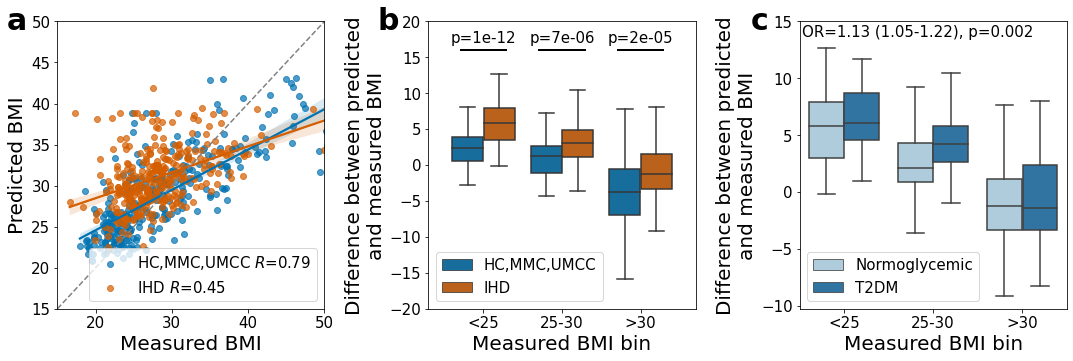

In [86]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
labels_fontsize = 20
tick_fontsize = 15
show_r2 = False
colors = sns.color_palette('Paired', 10)

def pearsonr_rmna_return_r(x, y):
    return pearsonr_rmna(x, y)[0]

if show_r2:
    method = r2_score_rmna
    r2_label = '$R^2$'
else:
    method = pearsonr_rmna_return_r
    r2_label = '$R$'



# age_bins = [35, 40, 50, 60, 70]
bmi_bins = [15, 25, 30, 60]

ax = axes[0]
y, yy = y_bmi, healthy_pred_age_sex_bmi.loc[y_bmi.index, 'BMI_C']
r2 = method(y, yy)
sns.regplot(y, yy, color=healthy_color, label='HC,MMC,UMCC %s=%0.2f'%(r2_label, r2), ax=ax, scatter_kws={'alpha':0.7})
y, yy = y_bmi_acs, acs_pred_age_sex_bmi.loc[y_bmi_acs.index, 'BMI_C']
r2 = method(y, yy)
sns.regplot(y, yy, color=acs_color, label='IHD %s=%0.2f'%(r2_label, r2), ax=ax, scatter_kws={'alpha':0.7})
ax.plot([15, 50], [15, 50], '--', color='grey')
ax.set_xlim((15, 50))
ax.set_ylim((15, 50))
ax.set_xlabel('Measured BMI', fontsize=labels_fontsize)
ax.set_ylabel('Predicted BMI', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.legend(loc='lower right', fontsize=tick_fontsize)

ax = axes[1]
df = pd.DataFrame(index=y_bmi.index.tolist() + y_bmi_acs.index.tolist(), columns=['x', 'y', 'z'])
y, yy = y_bmi, healthy_pred_age_sex_bmi.loc[y_bmi.index, 'BMI_C'].values - y_bmi.values
df.loc[y_bmi.index, 'x'] = y.values
df.loc[y_bmi.index, 'y'] = yy
df.loc[y_bmi.index, 'z'] = 'HC,MMC,UMCC'
y, yy = y_bmi_acs, acs_pred_age_sex_bmi.loc[y_bmi_acs.index, 'BMI_C'].values - y_bmi_acs.values
df.loc[y_bmi_acs.index, 'x'] = y.values
df.loc[y_bmi_acs.index, 'y'] = yy
df.loc[y_bmi_acs.index, 'z'] = 'IHD'

df['x'] = df['x'].astype(float)
df['y'] = df['y'].astype(float)
df['bin'] = pd.cut(df.x, bmi_bins)
df = df.sort_values(['z', 'bin'])
bmi_diff_bins = df.dropna().copy()
# bmi_diff_bins['bin'] = bmi_diff_bins['bin'].dropna().astype(str).replace({'(20, 25]':'<25', '(25, 30]':'25-30', '(30, 35]':'30-35', '(35, 40]':'>35'})
bmi_diff_bins['bin'] = bmi_diff_bins['bin'].dropna().astype(str).replace({'(15, 25]':'<25', '(25, 30]':'25-30', '(30, 60]':'>30'})
sns.boxplot(x='bin', y='y', data=bmi_diff_bins, hue='z', ax=ax, palette=[healthy_color, acs_color], showfliers=False)

ax.set_xlabel('Measured BMI bin', fontsize=labels_fontsize)
ax.set_ylabel('Difference between predicted\nand measured BMI', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.legend(loc='lower left', fontsize=tick_fontsize)
ax.set_ylim((-20, 20))

for b, xx in zip(bmi_diff_bins['bin'].unique(), [0, 1, 2]):
    x, y = bmi_diff_bins[(bmi_diff_bins['z'] == 'HC,MMC,UMCC') & (bmi_diff_bins['bin'].astype(str) == b)].dropna()['y'], \
           bmi_diff_bins[(bmi_diff_bins['z'] == 'IHD') & (bmi_diff_bins['bin'].astype(str) == b)].dropna()['y']
    t, p = directed_mannwhitneyu(x, y)
    ax.text(xx, 17,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
    ax.hlines(y=16, xmin=xx-0.3, xmax=xx+0.3, linewidth=2, color='black')
    
ax = axes[2]
c = 'DiabetesStatus'
data['bmi bin'] = pd.cut(data['BMI_C'], bmi_bins).astype(str).replace({'(15, 25]':'<25', '(25, 30]':'25-30', '(30, 60]':'>30'})
sns.boxplot(x='bmi bin', y='acs bmi diffs', data=data.sort_values('BMI_C').replace({c:{0:'Normoglycemic', 1:'T2DM'}}), ax=ax, palette=colors, 
            hue=c, showfliers=False)
ax.set_xlabel('Measured BMI bin', fontsize=labels_fontsize)
ax.set_ylabel('Difference between predicted\nand measured BMI', fontsize=labels_fontsize)
leg = ax.legend(loc='lower left', fontsize=tick_fontsize, title='')
leg.get_title().set_fontsize(str(tick_fontsize))
ax.tick_params(labelsize=tick_fontsize)
ax.set_yticks([-10, -5, 0, 5, 10, 15])
add_text_at_corner(ax, 'OR=%0.2f (%0.2f-%0.2f), p=%0.1g'%(logit_results.loc[c, 'coef'], logit_results.loc[c, '0.025'], 
                                                          logit_results.loc[c, '0.975'] ,logit_results.loc[c, 'pval']), 'top left', fontsize=tick_fontsize)    
    
fig.tight_layout()
plt.text(-0.15, 1.0, 'a', ha='center', va='center', transform=axes[0].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.15, 1.0, 'b', ha='center', va='center', transform=axes[1].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.15, 1.0, 'c', ha='center', va='center', transform=axes[2].transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(metacardis_dir, 'ExtendedDataFigure_MetaCardis_a-c.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(metacardis_dir, 'ExtendedDataFigure_MetaCardis_a-c.pdf'), dpi=300, bbox_inches='tight')

# SHAP

In [87]:
# TODO: add  'Glucose Disorder: DM2' as covariate - ['BMI_C', 'const', 'Glucose Disorder: DM2']

ps = acs_shap_values_dic['metabolon']['BMI_C'].loc[y_bmi_acs.index].apply(lambda x: OLS(metacardis_X_age_bmi.reindex(y_bmi_acs.index)
                                                                                        ['acs bmi diffs'], pd.concat((metacardis_X_age_bmi.reindex
                                                                                                                      (y_bmi_acs.index)
                                                                                                                      [['BMI_C', 'const', 'DiabetesStatus']], x), 
                                                                                                                     axis=1, sort=False), 
                                                                                        missing='drop').fit().pvalues.loc[x.name])
rs = acs_shap_values_dic['metabolon']['BMI_C'].loc[y_bmi_acs.index].apply(lambda x: OLS(metacardis_X_age_bmi.reindex(y_bmi_acs.index)
                                                                                        ['acs bmi diffs'], pd.concat((metacardis_X_age_bmi.reindex
                                                                                                                      (y_bmi_acs.index)
                                                                                                                      [['BMI_C', 'const', 'DiabetesStatus']], x), 
                                                                                                                     axis=1, sort=False), 
                                                                                        missing='drop').fit().params.loc[x.name])
fdr_correction(ps.dropna(), alpha=0.01)[0].sum()

78

In [89]:
df = pd.concat((ps.sort_values().dropna().rename('SHAP-delta BMI pvalue'), rs.rename('SHAP-delta BMI coef'), 
          metacardis_serum_metabolomics.loc[y_bmi.index, ps.sort_values().dropna().index].apply(lambda x: spearmanr(x, metacardis_X_age_bmi.loc[y_bmi.index, 'BMI_C'], nan_policy='omit')[0]).rename('metabolite-BMI in healthy cohort Spearman rho'),),
          axis=1).dropna().rename_axis('CHEMICAL_ID')
df['SHAP-delta BMI qvalue'] = fdr_correction(df['SHAP-delta BMI pvalue'])[1]
df[df['SHAP-delta BMI qvalue']<0.01].to_csv(os.path.join(metacardis_dir, 'Supplementary_table_metabolon_bmi_shap_drivers.csv'))

In [90]:
acs_shap_table = pd.read_csv(os.path.join(paper_dir, 'metabolomics_model_of_age_and_bmi', 'GBDT', 'Train-Test', 'no-albumin-glucose-creatinine',
                                          'Supplementary_table_metabolon_bmi_shap_drivers.csv'), index_col=0)
acs_shap_table.index = acs_shap_table.index.astype(str)

In [94]:
metabolon_res[metabolon_res.CHEMICAL_ID == '100002462']

,BIOCHEMICAL,Logit coef,Logit pval,Logit 0.025,Logit 0.975,directional pval,Enriched in ACS,Logit qval,CHEMICAL_ID
487,5-(galactosylhydroxy)-L-lysine,0.445804,0.017345,1.081742,2.25474,1.760835,True,0.034085,100002462


In [91]:
df.reindex(acs_shap_table.index)

,SHAP-delta BMI pvalue,SHAP-delta BMI coef,metabolite-BMI in healthy cohort Spearman rho,SHAP-delta BMI qvalue
CHEMICAL_ID,,,,
100009007,2.732600e-04,2.074239,-0.600904,0.002224
100005403,1.723595e-03,13.566583,-0.100080,0.010860
100009027,1.439473e-01,9.856464,0.315531,0.309545
100020902,NaN,NaN,NaN,NaN
100002462,2.206612e-01,9.743601,0.226547,0.400078
100009009,1.099271e-07,7.593710,-0.524892,0.000003
235,4.854635e-01,23.976422,-0.014471,0.636551
1547,4.621827e-01,1.754201,0.325842,0.627066
803,9.629184e-01,0.036880,0.489504,0.981611
